<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем нужные инструменты:

In [33]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

In [34]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [35]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [36]:
#проверим пропуски:
df.isna().sum()

num_orders    0
dtype: int64

Данные загрузили, пропусков нет. При помощи аргументов при импорте данных сделали строку с датами индексной. Данные отсортированы по 10 минут. Применим ресемплирование и сделаем интервал часовым:

In [37]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Осталось проверить индекс на последовательность:

In [38]:
df.index.is_monotonic

True

Успех. Данные последовательны. Переходим к анализу.

## Анализ

### Анализ данных

Разложим временной ряд на сезонную составляющую, тренд и остаточные данные. Отобразим данные на графиках. 

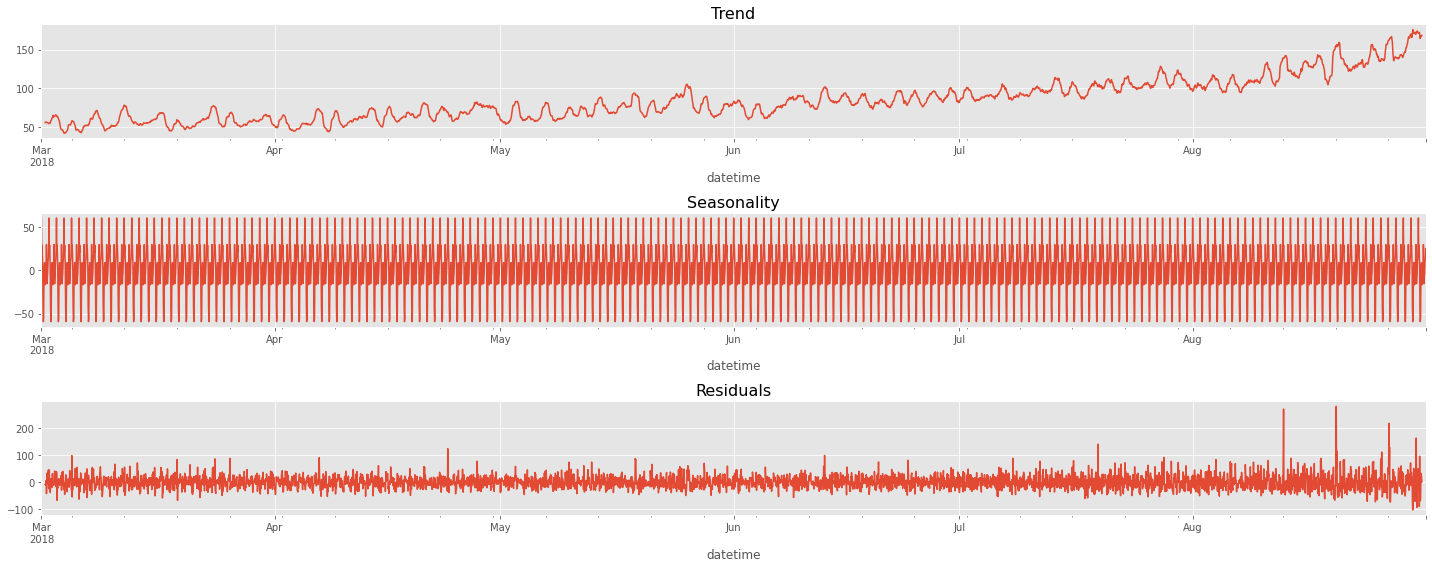

In [39]:
decomposed = seasonal_decompose(df.num_orders)

plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', size=16)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality', size=16)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals', size=16)

plt.tight_layout()

Тренд явно восходящий, осенью люди стали заметно чаще пользоваться такси. Сезонность прослеживается ежедневно. Для лучшего качества модели, стоит создать еще признаки. 

<AxesSubplot:title={'center':'Seasonal'}, xlabel='datetime'>

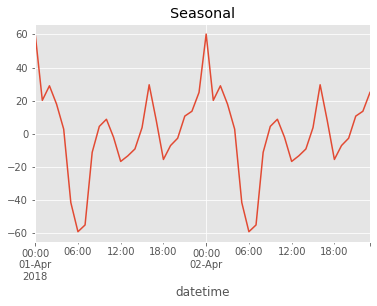

In [40]:
decomposed.seasonal['2018-04-01' : '2018-04-02'].plot(title='Seasonal')

Самый низкий спрос в 6 утра. Самый высокий в полночь. И так изо дня в день. 

Проверяем стационарность ряда тестом Дики — Фуллера. Для этого выдвинем две гипотезы - нулевую и альтернативную. 

- Нулевая гипотеза: ряд не стационарен
- Альтернативная: ряд стационарен

In [41]:
test_stat, p_val, _, _, crit_val, _ = sts.adfuller(df.num_orders)
test_stat

-3.068924289027945

In [42]:
p_val

0.028940051402613794

In [43]:
crit_val

{'1%': -3.431842162413052,
 '5%': -2.8621993540813637,
 '10%': -2.567120978470452}

p-значение меньше 0.05, значение статистики меньше критических на 5%  уровня значимости: нулевую гипотезу можно отвергнуть и признать ряд стационарным. 

### Создание признаков

Для улучшения качества модели, создадим несколько признаков. 

In [44]:
# cоздадим специально для этого функцию:
def make_features(df, max_lag, rolling):
    df['day'] = df.index.day # добавим день
    df['hour'] = df.index.hour # добавим час
    df['dayofweek'] = df.index.dayofweek # и добавим день недели
 
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(2*lag)
 
    for i, roll in zip(range(len(rolling)), rolling):
        df['rolling_mean_{}'.format(i)] = df['num_orders'].shift().rolling(roll).mean()

Добавим признаки отстающих значений и скользящее среднее

In [45]:
rolling = [5, 13]
make_features(df, 8, rolling)

Разделим датасет на обучающую и тестовую выборку в соотношении 9:1

In [46]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(['num_orders'], axis=1), df['num_orders'], test_size=0.1, shuffle=False, random_state=12345) 

## Обучение

### CatBoost

Обучим две модели - линейную регрессию и CatBoost. Подберем сначала параметры для CatBoost.

In [47]:
tscv = TimeSeriesSplit(n_splits=3) # corectly split time series data

model = CatBoostRegressor(loss_function='RMSE',
                          verbose=100,
                          thread_count=-1,
                          random_seed=12345)

grid = {'depth': [4, 5, 6],
        'min_data_in_leaf':[3, 4, 5],
        'l2_leaf_reg': [3, 5, 9, 11, 13]
       }

grid_search_result = model.grid_search(grid,
                                       cv=tscv,
                                       X=features_train, 
                                       y=target_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 77.1095442	test: 112.3772348	best: 112.3772348 (0)	total: 2.45ms	remaining: 2.44s
100:	learn: 23.9108599	test: 41.7282655	best: 41.7282655 (100)	total: 202ms	remaining: 1.8s
200:	learn: 21.2974409	test: 35.1663086	best: 35.1663086 (200)	total: 386ms	remaining: 1.53s
300:	learn: 20.2196377	test: 33.0526492	best: 33.0526492 (300)	total: 592ms	remaining: 1.37s
400:	learn: 19.4927819	test: 32.1726660	best: 32.1726660 (400)	total: 781ms	remaining: 1.17s
500:	learn: 18.9548480	test: 31.8424094	best: 31.8384657 (499)	total: 986ms	remaining: 982ms
600:	learn: 18.5116825	test: 31.6729220	best: 31.6438857 (593)	total: 1.18s	remaining: 781ms
700:	learn: 18.0535940	test: 31.5494209	best: 31.5352841 (675)	total: 1.37s	remaining: 583ms
800:	learn: 17.6411851	test: 31.5043789	best: 31.4969884 (758)	total: 1.55s	remaining: 385ms
900:	learn: 17.2754632	test: 31.5609381	best: 31.4785258 (825)	total: 1.75s	remaining: 192ms
999:	learn: 16.9124026	test: 31.5288706	best: 31.4785258 (825)	total: 1.

In [48]:
print(f"Best CatBoost params: {grid_search_result['params']}")

Best CatBoost params: {'min_data_in_leaf': 3, 'depth': 4, 'l2_leaf_reg': 5}


### LinearRegression

Обучим модель линейной регрессии.

In [49]:
reg = LinearRegression()
reg.fit(features_train.dropna(), target_train[features_train.dropna().index])

LinearRegression()

In [50]:
predicted_reg = reg.predict(features_train.fillna(0))
predicted_catboost = model.predict(features_train.fillna(0))

print(f'RMSE LinearRegression:   {mean_squared_error(target_train, predicted_reg, squared=False)}')
print(f'RMSE CatBoostRegression: {mean_squared_error(target_train, predicted_catboost, squared=False)}')

RMSE LinearRegression:   32.91882340307937
RMSE CatBoostRegression: 18.897444698703268


CatBoost почти "в два раза лучше".

## Тестирование

In [51]:
predicted_reg = reg.predict(features_test)
predicted_catboost = model.predict(features_test)

print(f'RMSE LinearRegression:   {mean_squared_error(target_test, predicted_reg, squared=False)}')
print(f'RMSE CatBoostRegression: {mean_squared_error(target_test, predicted_catboost, squared=False)}')

RMSE LinearRegression:   56.762014172656066
RMSE CatBoostRegression: 43.346099250783396


Обучим константуную модель.

In [52]:
dr = DummyRegressor()
dr.fit(features_test, target_test)
predicted_dr = dr.predict(features_test.fillna(0))
print(f'RMSE DummyRegressor: {mean_squared_error(target_test, predicted_dr, squared=False)}')

RMSE DummyRegressor: 58.549609354757315


График сравнения предсказания и реальных значений:

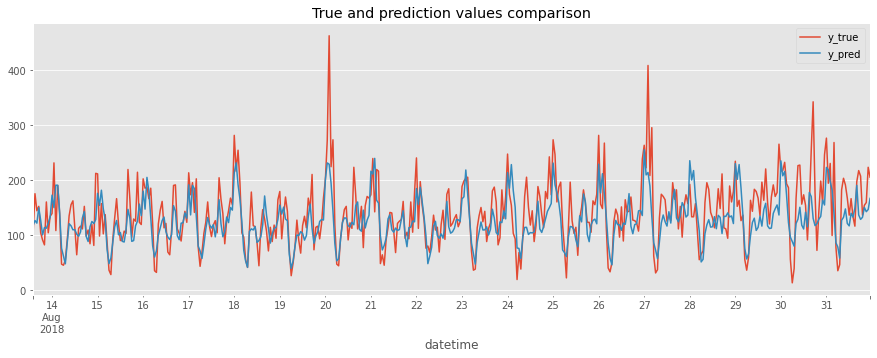

In [54]:
true_pred = pd.DataFrame({ 
    'y_true' : target_test,
    'y_pred' : model.predict(features_test)
    })


true_pred.plot(figsize=(15,5), title='True and prediction values comparison');

Константная модель явно хуже наших моделей. 

График демонстрирует хорошую прямую  корреляцию предсказаний и реальных значений. 

## Вывод

- Был првоеден анализ данных, проверены пропуски. Был выявлен тренд на увеличение количества заказов осенью, и ежедневная сезонность. 
- Добавили новые признаки: час заказа, день недели, день, скользящее среднее значений и отстающие значения.
- С помощью кросс-валидации подобрали лучшие параметры для CatBoostRegression
- Добились RMSE на тестовой выборке меньше 48, как и требовалось.
- Модель CatBoostRegression оказалась лучше LinearRegression - RMSE 43.34 против 56.76 соответственно. 